# 一、優化 CNN 的方法

*****

## 1. 改善 Gradient Vanishing 問題

為了使神經網路有更好的收斂效果，我們會希望每一層輸入的特徵(即 x tensor)都呈現常態分布，達到此目的的發法就是正規化(Normalization)。如果沒有經過 normalization ，會造成 scale 差距過大，計算 gradient 時會忽大忽小產生 Zig-Zag ，模型也會為了要學習不同特徵分布的差異，而收斂緩慢。
以兩個變數的 loss function 說明：

$$J(\theta_{1},\theta_{2})=\theta_{1}x_{1}+\theta_{2}x_{2}$$

畫出 loss function ，比較 normalization 前後可以發現，經過 normalization ，收斂效果較佳。

|Before Normalization|After Normalization|
|:------------------:|:-----------------:|
|<img src="https://data-sci.info/wp-content/uploads/2017/06/loss_1.png" alt="Drawing" style="width: 250px;"/>|<img src="https://data-sci.info/wp-content/uploads/2017/06/loss_2.png" alt="Drawing" style="width: 250px;"/>|

但是 x tensor 經過神經網路運算後，會經過一層激活函數(Activation Function)，往往會將特徵的分布往集中或極端的方向拉，例如下圖為一10層的神經網路，每層有500個 hidden unit ， weight 初始值是從 $Gaussian(0,0.01)$ 隨機抽樣， activation function 採用 $tanh$ 。上圖由左到下分別為每層輸出平均、標準差和分佈。我們可以看到在第3層以後輸出幾乎都在0附近，這會造成最後面幾層的 gradient 非常小，非常小的 gradient 再往前傳會更小，於是到最後 gradient 幾乎等於0，此現象即為 Gradient Vanishing 。 Gradient Vanishing 後 weight 就失去了更新的方向，於是 model 就 train 不動了。

<img src="https://data-sci.info/wp-content/uploads/2017/06/%E8%9E%A2%E5%B9%95%E5%BF%AB%E7%85%A7-2017-06-11-%E4%B8%8B%E5%8D%889.17.22.png" alt="Drawing" style="width: 800px;"/>

為了改善此問題，有以下幾種方法：

### (1) Xavier Initialization → He Initialization

Xavier Initialization 是讓 weight 的初始值是具有特定的變異數的高斯分布：

$$Var(W)=\frac{1}{n_{in}}$$

其中， $W$ 表示初始化的 weight ， $n_{in}$ 表示 neuron 的個數。

原理：

Suppose we have an input $X$ with $n$ components and a **linear** neuron with random weights $W$ that spits out a number $Y$. The variance of $Y$ is

$$Y=W_{1}X_{1}+W_{1}X_{1}+\dotsb+W_{n}X_{n} $$

And,

$$\text{Var}(W_iX_i) = E[X_i]^2 \text{Var}(W_i) + E[W_i]^2 \text{Var}(X_i) + \text{Var}(W_i)\text{Var}(i_i)$$

If our inputs and weights both have mean 0, that simplifies to

$$\text{Var}(W_iX_i) = \text{Var}(W_i)\text{Var}(X_i)$$

Then if we make a further assumption that the $X_{i}$ and $W_{i}$ are all independent and identically distributed,

$$\text{Var}(Y) = \text{Var}(W_1X_1 + W_2X_2 + \dotsb + W_n X_n) = n\text{Var}(W_i)\text{Var}(X_i)$$

The variance of the output is the variance of the input, but scaled by $nVar(W_{i})$. So if we want the variance of the input and output to be the same, that means $nVar(W_{i})$ should be 1. Which means the variance of the weights should be

$$\text{Var}(W_i) = \frac{1}{n} = \frac{1}{n_\text{in}}$$

然而 Xavier Initialization 建立在線性的激活函數的假設上，對於 $tanh$, $sigmoid$ 等非線性的激活函數可使用 He, Rang, Zhen and Sun 等人提出的 He Initialization:

$$Var(W)=\frac{2}{n_{in}}$$

### (2) Batch Normalization

S. Ioffe 和 C. Szegedy 在2015年發表《Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift》，提出Batch Normalization(BN)這個加速訓練的方法。採取 mini-batch 訓練方式通常會將資料分成小批小批進行 Stochastic Gradient Descent(SGD)，如果在每批資料進行 Forward-Propagation 的時候，都對每一層進行 normalization 的處理就能大幅加快收斂速度。因為隨著前面各層的累計影響，會導致某一層的特徵落在激活函數層的飽和區域，normalization 等同於對該特徵做變換，使之處於較好的非線性區域，所以 BN 被添加在每一個卷積層或全連接層和激活函數層之間可使得訊號傳播更有效。

以下是整個 BN 演算法的公式：

<img src="https://kratzert.github.io/images/bn_backpass/bn_algorithm.PNG" alt="Drawing" style="width: 450px;"/>

分別求出每一批訓練特徵的平均值、變異數，再對該批特徵做正規化處理，其中 $\epsilon$ 是為了防止變異數為0導致特徵計算的不穩定而添加的一個微小數值，如1e−6。

但是將正規化後的特徵直接交給非線性激活函數，如 $sigmoid$ ，則特徵會被限制在線性區域，這樣改變了原始特徵的分佈。

<img src="https://images2017.cnblogs.com/blog/606386/201709/606386-20170922200109431-162779928.png" alt="Drawing" style="width: 450px;"/>

所以論文中還引入兩個可學習的參數 $\gamma$ 、 $\beta$ 以還原原始特徵分佈，這兩個參數學習的目標是：

$$\gamma=\sqrt{\text{Var}[X]}$$
$$\beta=\mathbb E[X]$$

其中 $X$ 表示所有樣本在該層的特徵，原來的分佈的平均值、變異數由前層的各種參數和weight耦合控制，而現在僅由 $\gamma$ 、 $\beta$ 控制，很容易通過梯度下降來學習，這樣在保留 BN 層足夠的學習能力的同時，使其學習更加容易。

在訓練時計算 mini-batch 的平均值和變異數並進行 Backward-Propagation ，而測試時並沒有 batch 的概念，所以訓練完畢後需要提供固定的 $\bar\mu$ 、 $\bar\sigma$ 供測試時使用。在訓練時一併對所有的 mini-batch 的 $\mu_\mathcal B$ 、 $\sigma^2_\mathcal B$ 使用 moving average 的方式取得平均值( $m$ 是 mini-batch 的大小、 $\bar\sigma^2$ 採用的是無偏估計值)。

$$\bar\mu =\mathbb E[\mu_\mathcal B]$$
$$\bar\sigma^2 ={m\over m-1}\mathbb E[\sigma^2_\mathcal B]$$

### (3) Selu(Self-Normalizing ReLU)

在2017年發表的《Self-Normalizing Neural Networks》這篇論文中， Günter Klambaue, Thomas Unterthiner, Andreas Mayr 等人從本質上去改進 Activation Neuron ，使其在數學上具有自動讓輸出值收斂到 mean = 0, std =1 ，即便是在有 noise 的情況下。而就算 std 不收斂到1，作者們也給出了上下界。這神奇的Selu Function長的這副模樣：

$$Selu(x) = \lambda\ \begin{cases} x, & \mbox{if } x\mbox{ > 0} \\ \alpha{e^{x}}-\alpha, & \mbox{if } x\mbox{ $\leq$ 0} \end{cases}$$

while,

$$\begin{cases} \lambda=1.0507009873554804934193349852946 \\ \alpha=1.6732632423543772848170429916717 \end{cases}$$

實測結果媲美Batch Normalization，真令人不禁佩服作者們居然想的到這數學公式啊！

<font size=5>**尚有以下方式可採用**</font>

##  2. 讓 Dropout 比例不一

### Differential Dropout

*****

## 3. 隨機打亂資料

### Random Shuffling

*****

## 4. 考慮模型複雜度的懲罰值

### L2 Regularization

<img src="http://laid.delanover.com/wp-content/uploads/2018/01/reg_formulas.png" alt="Drawing" style="width: 450px;"/>

<img src="https://rasbt.github.io/mlxtend/user_guide/general_concepts/regularization-linear_files/l2.png" alt="Drawing" style="width: 450px;"/>

# 二、實驗過程

*****

## 1. 先調整 epochs、batch_size、keep_probability 等參數，以及模型 layer 架構

過程中發現若是在 conv_net 中把 conv_num_outputs 調得太大(大於24左右)，以及batch_size調得太大(若架多層只能夠調整在128)，會造成 OOM Problem(GPU的記憶體不夠存數據)。

所以我只讓 conv_net 放一層 conv2d_maxpool ， 一層 fully_conn ， Testing Accuracy 為 71.76%。

<img src="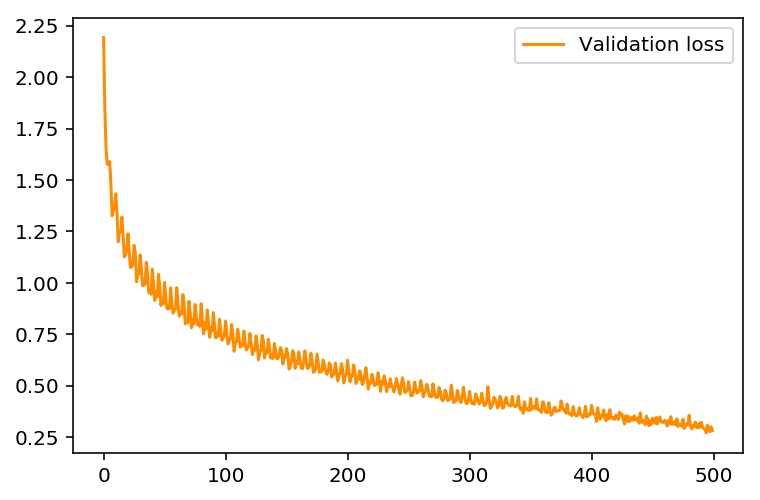&#10;" width="380" height="250">

<img src="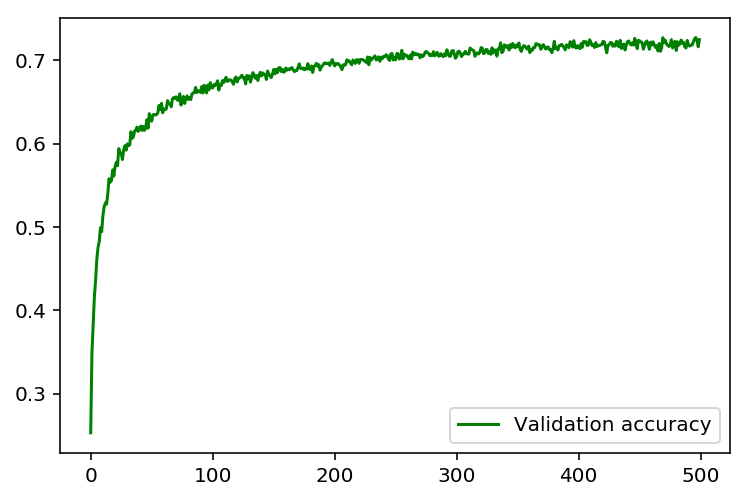&#10;" width="373" height="250">

為了在此限制下提升準確率，便使用上述幾種方法。

## 2. 使用 Xavier Initialization

因為採用 relu 這非線性的激活函數，所以需要使用改良版的 He Initialization ， Accuracy 有明顯提升。

## 3. 使用 Xavier Initialization + Batch Normalization

Testing Accuracy 提升至 75.02%。

<img src="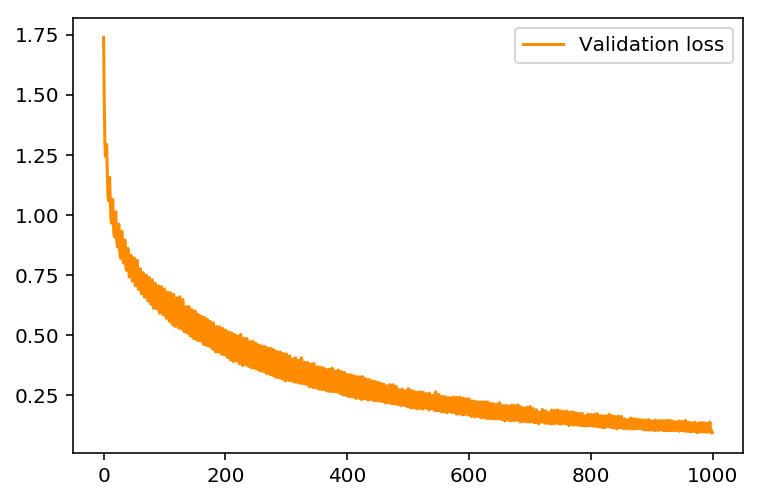&#10;" width="380" height="250">

<img src="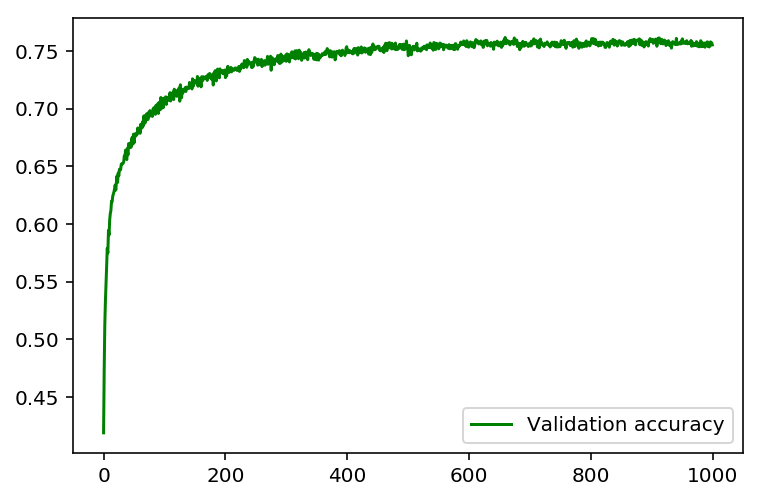&#10;" width="380" height="250">

## 4. 單獨使用 Selu

此時 Testing Accuracy 就已經提升至 74.62%，可見 selu 這個特別的激活函數的威力。


## 5. 使用 Xavier Initialization + Selu

Testing Accuracy 為 74.72%，媲美BN的效果。

<img src="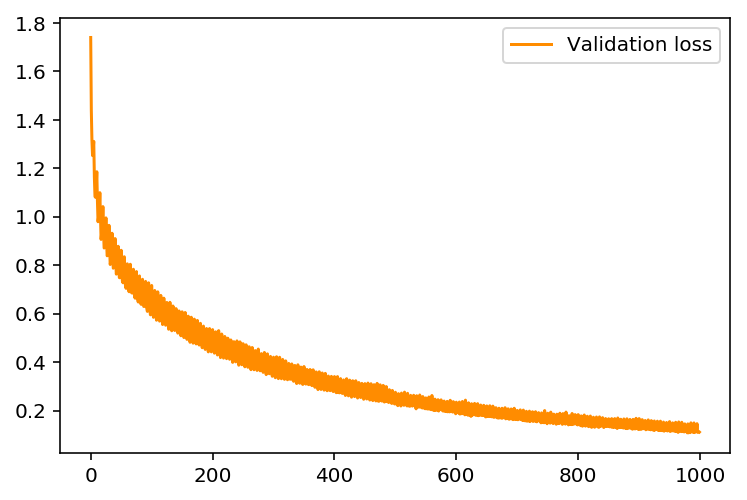&#10;" width="373" height="250">

<img src="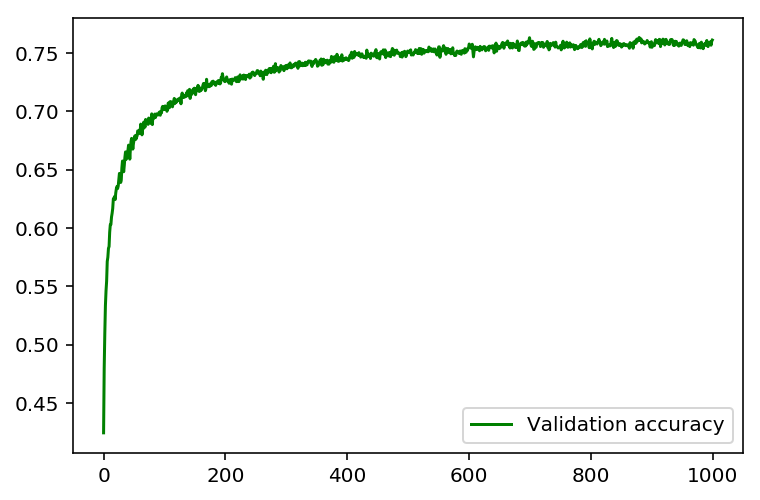&#10;" width="380" height="250">

## 6. 使用 Multi- layer 的模型架構

原本以為只能接單層不然會 OOM ，後來發現只要參數調在某個範圍內，還是能使用多層的架構。

### (1) Xavier Initialization + Selu with Multi-layer

Testing Accuracy 為 76.44%

<img src="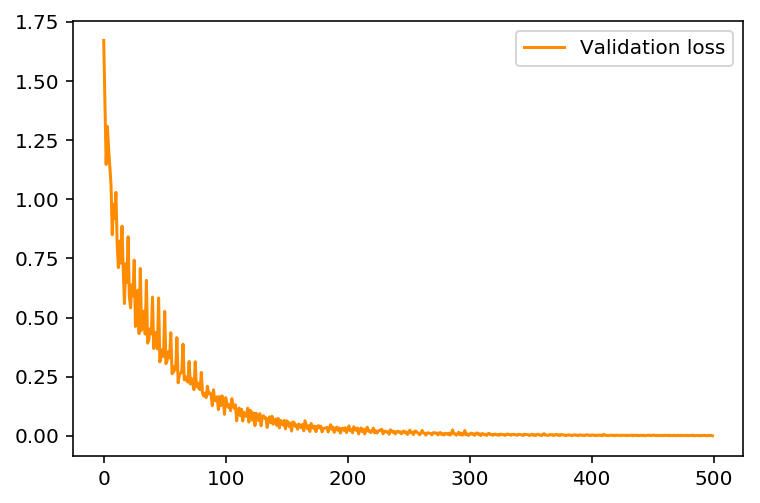&#10;" width="380" height="251">

<img src="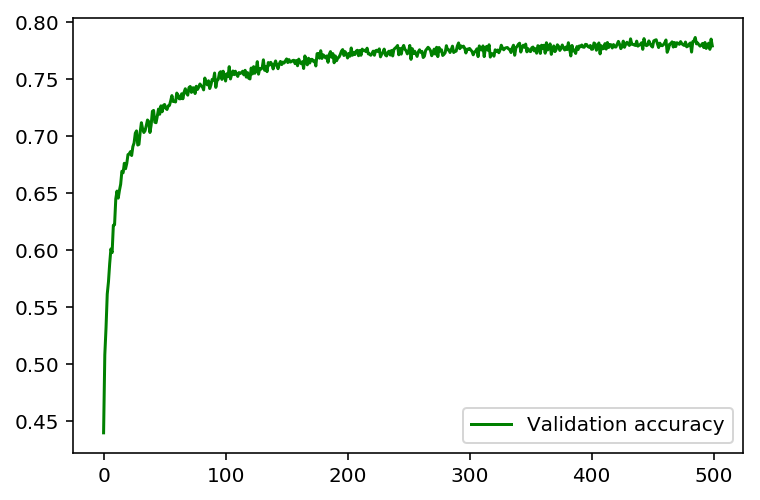&#10;" width="380" height="250">

### (2) Xavier Initialization + Selu with Multi-layer

經過多次嘗試，最終讓 Testing Accuracy 提升至 77.10%。


# 三、實驗參數整理
|method|architecture|epochs|batch_size|keep_probability|conv_num_outputs|conv_ksize|conv_strides|pool_ksize|pool_strides|fully_conn_num_outputs|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|Orinial|1層CNN+<br>1層FC|100|512|0.3|20|3 x 3|1 x 1|8 x 8|1 x 1|500|
|Xavier+BN|1層CNN+<br>1層FC|100|512|0.3|20|3 x 3|1 x 1|8 x 8|1 x 1|500|
|Selu|1層CNN+<br>1層FC|100|512|0.3|20|3 x 3|1 x 1|8 x 8|1 x 1|500|
|Xavier+Selu|1層CNN+<br>1層FC|100|128|0.3|24|3 x 3|1 x 1|2 x 2|1 x 1|512|
|Xavier+BN<br>with Multilayer|6層CNN+<br>2層FC<br>(每2層1個dropout)|100|128|0.3|24|3 x 3|1 x 1|2 x 2|1 x 1|512|
|Xavier+Selu<br>with Multilayer|6層CNN+<br>2層FC<br>(每2層1個dropout)|100|128|0.3|24|3 x 3|1 x 1|2 x 2|1 x 1|512|


# 四、Reference

- Gradient Vanishing Problem: <https://goo.gl/4fhSXo>
- Xavier Initialization: <http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization>
- CNN Xavier Initialization: <https://stats.stackexchange.com/questions/198840/cnn-xavier-weight-initialization>
- Batch Normalization:
    - <https://morvanzhou.github.io/tutorials/machine-learning/ML-intro/3-08-batch-normalization/>
    - <https://blog.csdn.net/hjimce/article/details/50866313>
    - <http://www.cnblogs.com/makefile/p/batch-norm.html>
    - <https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html>
- Self-Normalizing Neural Networks Paper: <https://arxiv.org/pdf/1706.02515.pdf>